# Module 4 Time Series Project <br>


Name: Hazel Donaldson <br>
Pace: Part-Time <br>
Review Date: 10/21/2019 <br>
Instructor Name: Victor Geislinger

# 1) Introduction <br>

In this project, we will be performing a time series analysis on historical housing data obtained from Zillow. We will discover the top 5 zipcodes a real estate developer should invest in (buy homes, renovate and rent to people). This investor is looking for busy, dense metropolitan areas with average house prices around the median. 

# 2) Import necessary libraries, functions and import dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [56]:
def melt_data(df): #from Flatiron school
    melted = pd.melt(df, id_vars=['ZipCode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def get_datetimes(df):
    return pd.to_datetime(df.columns.values[6:], format='%Y-%m')

def acf_pacf(df, alags=48, plags=48):
    '''Creates the ACF and PACF plots to 
    observe possible parameters for ARIMA model'''
    #Create figure
    fig,(ax1, ax2) = plt.subplots(2,1, figsize=(13,8))
    #Create ACF plot
    plot_acf(df, lags=alags, zero=False, ax=ax1)
    #PACF plot
    plot_pacf(df, lags=plags, ax=ax2)
    plt.show()
    
def seasonal_plot(df, N=13, lags=[12,24,36,48,60,72]):
    #differencing the rolling mean to find seasonality in acf plot
    fig,(ax1, ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = TS_80631 - TS_80631.rolling(N).mean()
    plot_acf(rolling.dropna(), lags=lags, ax=ax1)
    plot_pacf(rolling.dropna(), lags=lags, ax=ax2)
    plt.show();


def train_test(df):
    #Set training data before 2015
    train = df[:'2015-04']
    #Set test data starting 2015
    test = df['2015-05':]
    return train, test
  

def model_fit(df, pdq=(1,0,1), pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train, order= pdq, seasonal=pdqs)
    results = model.fit()
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show()
    return train, test, results

def forecast(df, pred_date, start_date):
    #make these global so they can be accessed later
    global pred
    global pred_conf
    
    #get predictions from specific date and calculate confidence intervals
    pred = output.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    
    #plot real vs predicted values
    rcParams['figure.figsize'] = 15,6
    
    #plot observed values
    ax = df[start_date:].plot(label='Observed')
    
    #plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-Step Forecast', alpha=.9)
    
    #plot range of confidence intervals
    ax.fill_between(pred_ci.index,
                   pred_ci.iloc[:,0],
                   pred_ci.iloc[:, 1], color = 'g', alpha=.5)
    #axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Monthly Returns')
    plt.legend()
    
    plt.show() 

def dynamic_forecast(zipcode, pred_date, start_date):
    #make variables global so they can be used outside of function
    global pred_dynamic
    global pred_dynamic_ci
    
    #get predictions from specific dates and calculate confidence intervals
    pred_dynamic = output.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    
    #plot dynamic forecast and confidence intervals
    ax = zipcode[start_date:].plot(label='Observed', figsize=(20,15))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
    
    ax.fill_between(pred_dynamic_ci.index,
                   pred_dynamic_ci.iloc[:, 0],
                   pred_dynamic_ci.iloc[:, 1], color='g', alpha=.3)
    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(start_date), zipcode_forecasted.index[-1], alpha=.1, zorder=-1)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Monthly Returns')
    plt.legend()
    plt.show()

def future_forecast_model(df, pdq=(1,0,1), pdqs=(0,0,0,1), display=True, zc='input zipcode'):
    '''Forecast time series data up to 10-years. outputs monthly
    returns after 1yr, 3yrs, 5yrs and 10yrs for each zipcode'''
    model = SARIMAX(df, order=pdq, seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04', end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:, 1],
                       color= 'k', alpha=.25, label='Confidence Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

In [3]:
zillow_df = pd.read_csv('zillow_data.csv')
zillow_df.head()
print(zillow_df.info(), '\n')
print(f'Unique amount of zipcodes: {zillow_df.RegionName.nunique()}')
zillow_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [ ]:
zillow_df.describe()

Looking at our data set, I can see that it is provided in wide-format. Further down, I will transform the data set into long format so that it is easier to read. There are 14,723 unique zipcodes in the data, so the next step will be to select the zipcodes that fit the investor's interests.

# 3) Data Preprocessing

Before choosing zipcodes that will suit the investor's interest, we will rename the RegionName column to zipcode for simplicity. Then below, we will filter the zipcodes that are higly urbanized and dense.

In [4]:
zillow_df.rename(columns={'RegionName':'ZipCode'}, inplace=True)
zillow_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
# Find the zipcodes that are in highly urbanized areas
print(zillow_df.SizeRank.describe())
#Calculate 20% cutoff point
srank_20 = zillow_df.SizeRank.quantile(q=0.20)
print(f'Size Rank 20% cutoff value: {srank_20}')
#New dataframe
top_20_zc = zillow_df[zillow_df['SizeRank'] < srank_20].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(top_20_zc)}')

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64
Size Rank 20% cutoff value: 2945.4
Amount of zipcodes: 2945


The number of zipcodes has been narrowed down to 2,945 from 14,723. Now I will narrow down the zipcodes to housing prices that hover around the median price. The average value will be calculated from last year's data as this the data the investor is mostly likely to encounter.

In [7]:
top_20_zc['yr_avg'] = top_20_zc.iloc[:,-12:].mean(skipna=True, axis=1)
print(top_20_zc['yr_avg'].describe())
q_60 = top_20_zc['yr_avg'].quantile(q=0.60)
q_35 = top_20_zc['yr_avg'].quantile(q=0.35)
print(f'Average Value for 60% cutoff rate: {round(q_60, 2)}')
print(f'Average Value for 35% cutoff rate: {round(q_35, 2)}')
pref_zc = top_20_zc[(top_20_zc['yr_avg'] < q_60) & (top_20_zc['yr_avg'] > q_35)]
print(f'Amount of zipcodes: {len(pref_zc)}')

count    2.945000e+03
mean     3.730666e+05
std      5.836511e+05
min      3.632500e+04
25%      1.691333e+05
50%      2.484083e+05
75%      3.978333e+05
max      1.858138e+07
Name: yr_avg, dtype: float64
Average Value for 60% cutoff rate: 290211.67
Average Value for 35% cutoff rate: 198641.67
Amount of zipcodes: 736


The number of zipcodes to consider is now 736. This takes in some of the requirements the investor is looking for: urbanization and median home value. Now, its time to look at things from an investment standpoint and calculate the return on investment and the coefficient of variance to take into account the risks involved. The return on investment or ROI is percentage increase in price. I will be calculating the ROI  between 2013-2018. This will represent the areas with the highest recent price uptrend. 

On the other hand, the investor will want to select areas where there is low volatility. It lowers risks when housing prices drop. The coefficient of variance is also used here, it's defined by the standard deviation divided by the mean. All 22 years of data is used here and null values are skipped. The higher the coefficient, the more volatile the zipcode.

In [8]:
pref_zc['roi'] = (pref_zc['2018-04']- pref_zc['2013-01'])/pref_zc['2013-01']
#calculate the standard deviation of monthly values between 1996 to 2018
pref_zc['std'] = pref_zc.loc[:,'1996-04': '2018-04'].std(skipna=True, axis=1)
#calculate historic mean
pref_zc['mean'] = pref_zc.loc[:, '1996-04': '2018-04'].mean(skipna=True, axis=1)
#calculate the coefficient of variance
pref_zc['CV'] = pref_zc['std']/pref_zc['mean']
#show calculated values
pref_zc[['ZipCode', 'std', 'roi', 'CV']].head(10)

,ZipCode,std,roi,CV
11,32162,53805.394161,0.227694,0.292910
14,37013,19771.938500,0.696557,0.142048
17,37211,36496.608464,0.798502,0.247623
18,78660,24894.592870,0.437537,0.148012
22,77573,29647.359699,0.412973,0.161776
23,77584,27064.756641,0.378291,0.143482
31,78130,23349.861603,0.410077,0.152247
38,77429,25209.719327,0.397936,0.141715
45,77433,28113.378077,0.335095,0.148727
51,30043,24035.181933,0.648415,0.142436


In [9]:
#descriptive statistics for coefficient of variance
print(pref_zc['CV'].describe())
#define an upper limit for CV
upper_cv = pref_zc.CV.quantile(q=0.60)
print(f'Upper CV limit: {upper_cv}')
#get zipcodes with highest ROIs within risk profile
best_zc = pref_zc[pref_zc.CV < upper_cv].sort_values('roi', ascending=False, axis=0)[:5]
best_zc[['ZipCode', 'roi', 'CV']].head(20)

count    736.000000
mean       0.238700
std        0.080020
min        0.056119
25%        0.171094
50%        0.226459
75%        0.291877
max        0.453303
Name: CV, dtype: float64
Upper CV limit: 0.25459687610566145


,ZipCode,roi,CV
1235,80631,1.037433,0.239795
2419,97233,0.983516,0.248805
422,78758,0.898876,0.228653
2693,98444,0.832353,0.244243
2005,37214,0.811351,0.216641


In [10]:
#get location names
best_zipcodes = list(best_zc.ZipCode.values)
for i in best_zipcodes:
    city = zillow_df[zillow_df['ZipCode']== i].City.values[0]
    state = zillow_df[zillow_df['ZipCode'] == i].State.values[0]
    print(f'Zipcode: {i}\n Location: {city}, {state}\n')

Zipcode: 80631
 Location: Greeley, CO

Zipcode: 97233
 Location: Portland, OR

Zipcode: 78758
 Location: Austin, TX

Zipcode: 98444
 Location: Parkland, WA

Zipcode: 37214
 Location: Nashville, TN



Now, we have the top 5 zipcodes based on our investor's interest. The data is still formatted in a wide format, with each month as a column. In order to perform a time series analysis, it needs to be formatted in long format, with month as a row.

In [12]:
TS_ZC5 = best_zc.drop(['yr_avg', 'std', 'mean', 'roi', 'CV'], axis=1)
TS_ZC5 =melt_data(TS_ZC5).set_index('time')
print('Time Series Data for top 5 zipcodes:\n', TS_ZC5.head())
dfs_ts = []
for zc in TS_ZC5.ZipCode.unique():
    df = TS_ZC5[TS_ZC5['ZipCode']==zc].asfreq('MS')
    dfs_ts.append(df)
dfs_ts[0].head()

Time Series Data for top 5 zipcodes:
             ZipCode     value
time                         
1996-04-01    80631   86500.0
1996-04-01    97233  110800.0
1996-04-01    78758  129000.0
1996-04-01    98444  100400.0
1996-04-01    37214   88300.0


,ZipCode,value
time,,
1996-04-01,80631,86500.0
1996-05-01,80631,87000.0
1996-06-01,80631,87500.0
1996-07-01,80631,87900.0
1996-08-01,80631,88400.0


# 4) EDA & Visualization

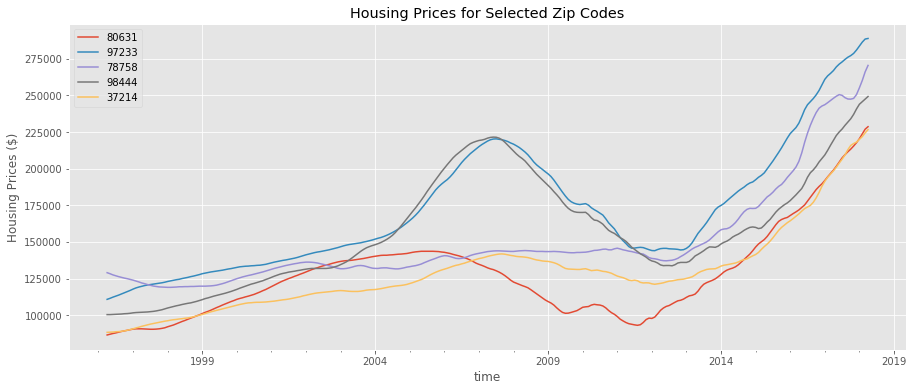

In [13]:
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].ZipCode[0], figsize=(15,6))
    plt.title('Housing Prices for Selected Zip Codes')
    plt.ylabel('Housing Prices ($)')
    plt.legend()

The graph above shows the prices are about the same for the 22 year period and I can see that the housing trends for Portland (97233) and Parkland(98444) got higher and fell around the time of the great housing crash and recession of 2009. There is a bit of the a dip in the Greeley(80631) trend around the time of the housing crash.

In [14]:
for i in range(len(dfs_ts)):
    print(f'Value descriptive statistics for zipcode {dfs_ts[i].ZipCode[0]}:')
    print(f'{dfs_ts[i].value.describe()}\n')

Value descriptive statistics for zipcode 80631:
count       265.000000
mean     127692.075472
std       30619.962378
min       86500.000000
25%      105000.000000
50%      123900.000000
75%      140900.000000
max      228600.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 97233:
count       265.000000
mean     171571.698113
std       42687.913348
min      110800.000000
25%      139400.000000
50%      158900.000000
75%      199100.000000
max      288800.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 78758:
count       265.000000
mean     149549.056604
std       34194.863952
min      119000.000000
25%      131900.000000
50%      139900.000000
75%      145000.000000
max      270400.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 98444:
count       265.000000
mean     157524.528302
std       38474.187065
min      100400.000000
25%      130400.000000
50%      150600.000000
75%      186400.000000
max     

Since most of the prices in the housing trend graph above are similar, we will need a better way to compare the zipcodes. We will look at the monthly returns because the returns are comparable to each other and prices are dependent to the previous price. The returns are more likely to be stationary and have a constant mean of zero.

In [15]:
# new column for monthly returns
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret'] = np.nan *len(dfs_ts)
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1] = (dfs_ts[zc].value.iloc[i+1]/dfs_ts[zc].value.iloc[i]) - 1

Before we can begin modeling, an important assumption needs to be confirmed: stationary. Stationary tells us that the mean is constant, the standard deviation is constant and there is not seasonality.

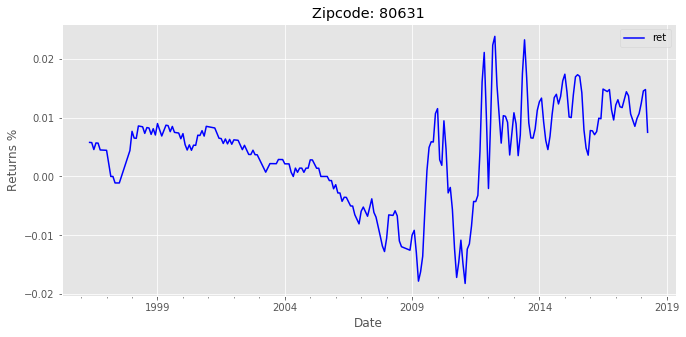

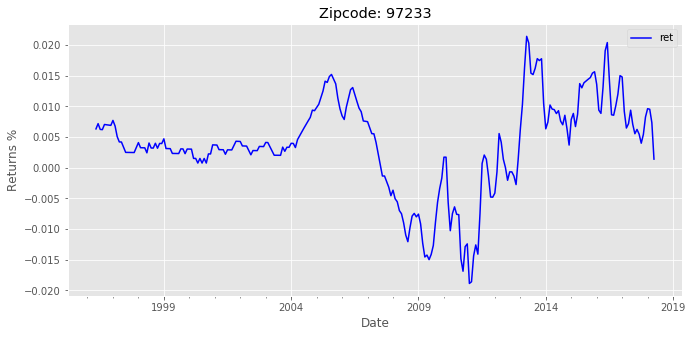

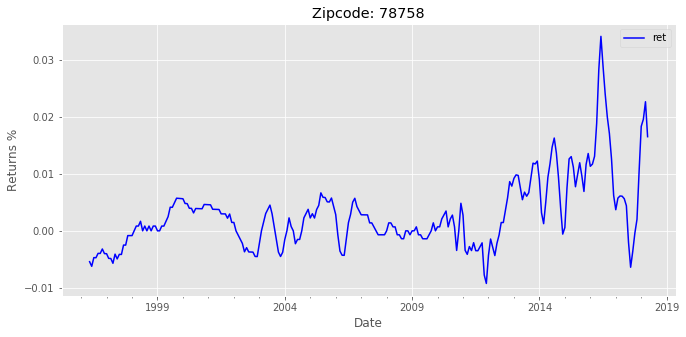

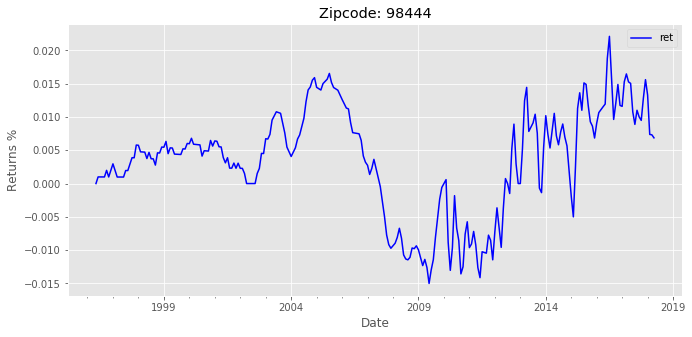

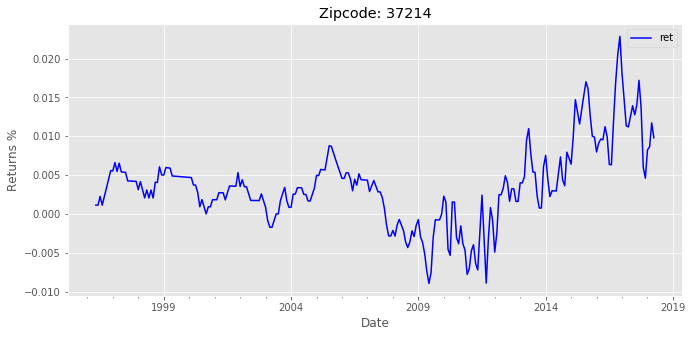

In [16]:
#plot the monthly returns for each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].ret.plot(figsize=(11, 5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].ZipCode[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns %')
    plt.legend(loc='best')
    plt.show()

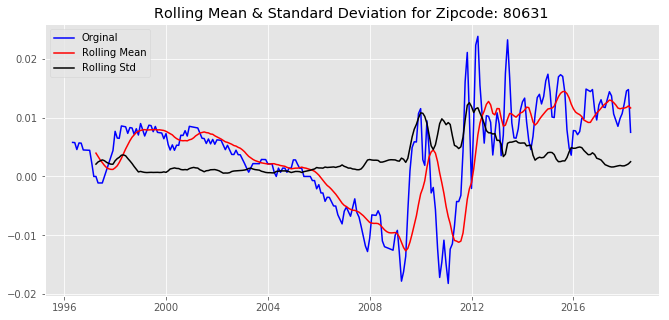

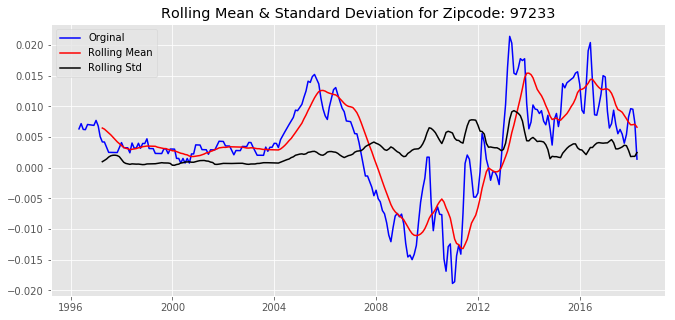

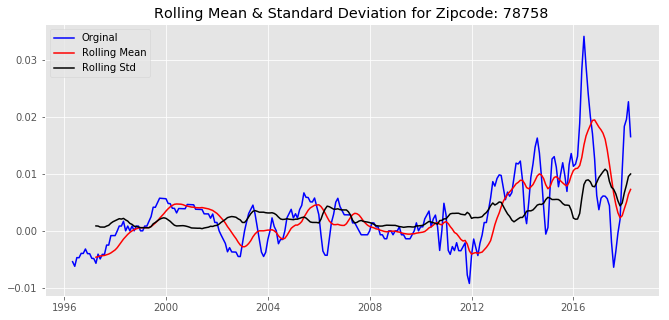

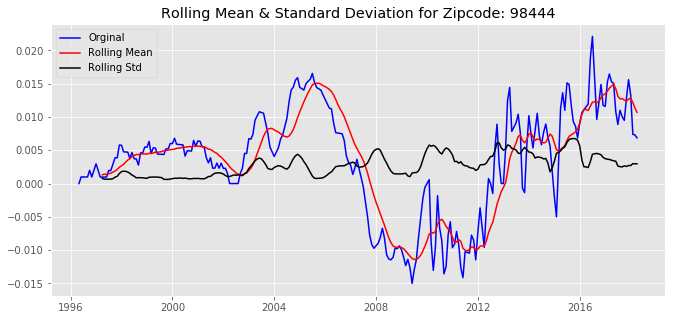

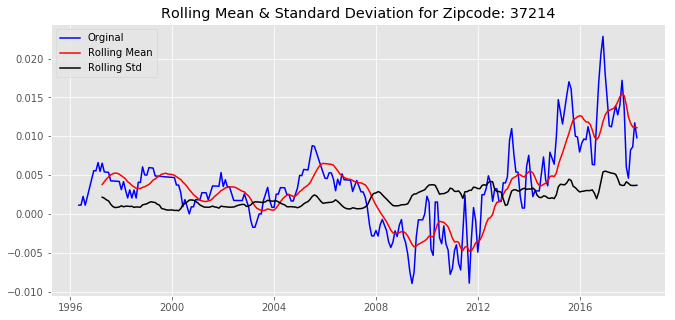

In [17]:
for i in range(len(dfs_ts)):
    rolmean= dfs_ts[i].ret.rolling(window=12, center=False).mean()
    rolstd = dfs_ts[i].ret.rolling(window=12, center=False).std()
    fig = plt.figure(figsize=(11, 5))
    orig = plt.plot(dfs_ts[i].ret,color='blue',label='Orginal')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].ZipCode[0]}')
    plt.show()

Visually, the data seems to not be stationary. However, we will challenge this visualizations using the Dickey-Fuller test and confirm whether or not the data is truly stationary. The Dickey-Fuller test is a statistical test of stationary in a time series. The null hypothesis of the Dickey-Fuller test say that the data is not stationary and the alternative hypothesis says the data is stationary. We will set the confidence level to 95% and we will reject the null hypothesis if there is p-value greater than 0.05.

In [18]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].ZipCode[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 80631
P-value 0.710539628008088
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 97233
P-value 0.11396395166248763
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 78758
P-value 0.17369935135771158
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 98444
P-value 0.3107084009520179
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 37214
P-value 0.5467030124705775
Fail to reject the null hypothesis. The data is not stationary.



As we can see above, none of the zipcodes are stationary and will need to take the first difference to see the effect on stationary.

In [19]:
#take the first order of intergration
for i in range(5):
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].ZipCode[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 80631
P-value 6.064327655106482e-10
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 97233
P-value 4.884612558355817e-08
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 78758
P-value 8.497498344953488e-09
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 98444
P-value 0.0006377881980377828
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 37214
P-value 2.7102862556018217e-07
Reject the null hypothesis. The data is stationary.



By taking the first difference of the data, all the data is now stationary. Moving forward, the I or integration for the ARIMA or SAMIRA model will be one. 

# 5) Time Series Analysis

In [20]:
#create individual times series for each zipcode
TS_80631 = dfs_ts[0].ret.dropna() #zipcode 80631 monthly returns time series
TS_80631d = dfs_ts[0].ret.diff().dropna() # differenced time series

TS_97233 = dfs_ts[1].ret.dropna()
TS_97233d = dfs_ts[1].ret.diff().dropna()

TS_78758 = dfs_ts[2].ret.dropna()
TS_78758d = dfs_ts[2].ret.diff().dropna()

TS_98444 = dfs_ts[3].ret.dropna()
TS_98444d = dfs_ts[3].ret.diff().dropna()

TS_37214 = dfs_ts[4].ret.dropna()
TS_37214d = dfs_ts[4].ret.diff().dropna()

## 5.1 Modelling Zipcode 80631

In [ ]:
acf_pacf(TS_80631d)

In [ ]:
seasonal_plot(TS_80631d, N=13)

As we can see, there is a statistically significant lag at 12 in the autocorrelation plot and a slight statistically significant lag at 24 months in the partial autocorrelation plot which lends credence to the fact that there is seasonality in the data. So, we can move forward with seasonal ARIMA model or SARIMA model. The ARIMA model is the most common method in time series analysis, which stands for Auto-Regressive Integrated Moving Average.

The ARIMA model has three components: AR (auto-regression, the p-value) component allows us to incorporate the effect of past values on our model. For example, the price of flowers may be high because the price of flowers has been high for the past few months. The AR terms are lags of the dependent variable. For instance, if p is 5, the predictors of x(t) will be x(t-1)...x(t-5). 
Number of differences of integration (d-value) is the value of the amount of differencing as it identifies the number of lags to subtract from the current observations. This is similar to saying that price of flowers is likely to be high because the difference in the price of flowers in the last couple of months was small. 
The MA(moving average: q-value) component of the model is a linear combination of error values observed at different points in the past. For instance if the q-value in a model is 2, then x(t)'s predictors are e(t-1) and e(t-2). The term s is the periodicity of the time series(4 is quarterly periods and 12 is annual periods).

In [21]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

The AIC value or Akaike Information Criterion provided by the statsmodels library. AIC is an estimator of the relative quality of the statistical model of a given data set and provides a mean of model selection. A model with many features that fits the data well will be assigned a larger AIC value than a model with fewer features to acheive the same goodness of fit. Therefore, we are interested in a lowest AIC value possible.

In [23]:
ans = []
for comb in pdq:    
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_80631,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =-1736.824343558046
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =-1679.9767104208252
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-1650.7550354590214
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-1643.3838459283695
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-1721.688883545294
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-1740.172562980943
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-1676.3175706306943
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-1668.0595793410357
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =-2018.7166614666448
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =-1944.256012903557
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-1870.6421235798725
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-1874.3251282217998
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-1986.4098588705524
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-1980.7012576117

In [24]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2362.11
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1016.616
Date:                Wed, 23 Oct 2019   AIC                          -2027.232
Time:                        11:21:05   BIC                          -2016.958
Sample:                    05-01-1996   HQIC                         -2023.086
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0606      0.092     -0.662      0.508      -0.240       0.119
ma.L1          0.5327      0.093      5.710      0.000       0.350       0.716
sigma2      7.517e-06   4.54e-07     16.544      0.0

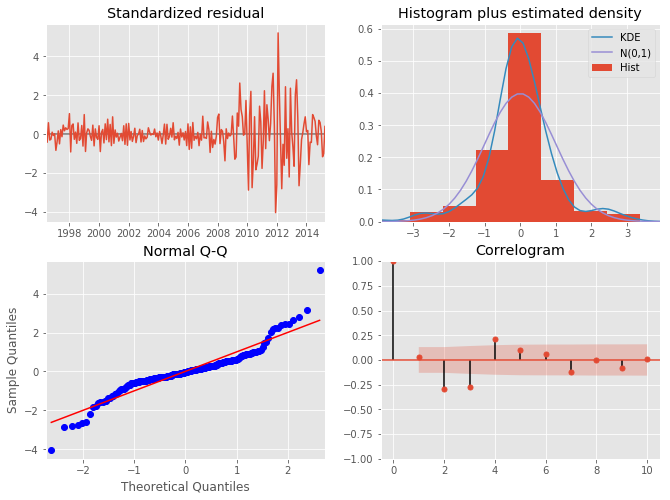

(time
 1996-05-01    0.005780
 1996-06-01    0.005747
 1996-07-01    0.004571
 1996-08-01    0.005688
 1996-09-01    0.005656
 1996-10-01    0.004499
 1996-11-01    0.004479
 1996-12-01    0.004459
 1997-01-01    0.004440
 1997-02-01    0.002210
 1997-03-01    0.000000
 1997-04-01    0.000000
 1997-05-01   -0.001103
 1997-06-01   -0.001104
 1997-07-01   -0.001105
 1997-08-01    0.000000
 1997-09-01    0.001106
 1997-10-01    0.002210
 1997-11-01    0.003308
 1997-12-01    0.004396
 1998-01-01    0.007659
 1998-02-01    0.006515
 1998-03-01    0.006472
 1998-04-01    0.008574
 1998-05-01    0.008502
 1998-06-01    0.008430
 1998-07-01    0.007315
 1998-08-01    0.008299
 1998-09-01    0.008230
 1998-10-01    0.007143
                 ...   
 2012-11-01    0.003643
 2012-12-01    0.007260
 2013-01-01    0.010811
 2013-02-01    0.008913
 2013-03-01    0.003534
 2013-04-01    0.007042
 2013-05-01    0.017483
 2013-06-01    0.023196
 2013-07-01    0.016793
 2013-08-01    0.009083
 2013-09-0

In [26]:
#Fit parameters for ARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
model_fit(TS_80631, pdq, pdqs)

From the above plots, we can see that the KDE curve is relatively close to the N(0,1) curve which indicates that the residuals are normally distributed. The Q-Q plot also shows us that the residuals are normally distributed because the blue dots(the residuals) are along the red line(normal distribution). The graph at the top left, doesn't show any obvious seasonality and appears to be white noise.This is confirmed with the graph at the bottom right because the time series residuals have a low correlation with lagged verisons of themselves.
 
The next step after fitting the model is to validate the model by comparing the predicted value to real values to the accuracy of our model.

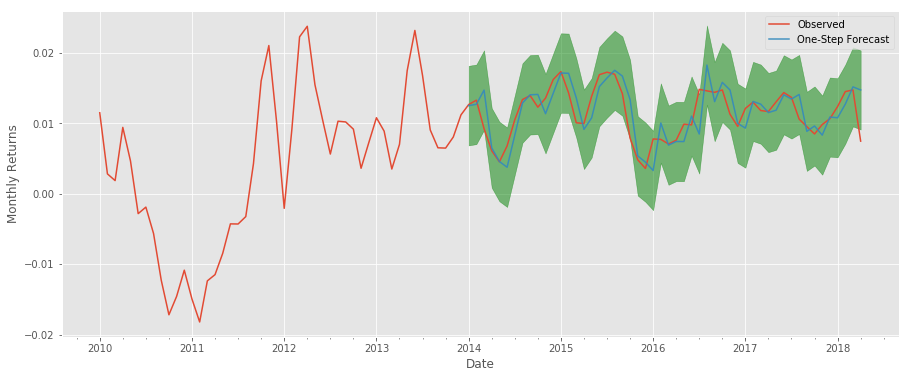

In [27]:
#from forecast function above
forecast(TS_80631,'2014-01-01', '2010-01-01')

As we can see from the graph above, the one step forecast seems to align with the true values very well. It will also be useful to quantity the accuracy of our forecasts. We will use the MSE or mean squared error, which summarizes the average error of our forecasts. 

In [ ]:
pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
#Plot observed values
ax = TS_80631['2010':].plot(lw=5)

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, lw=5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')
ax.legend(['Observed','One-Step Ahead Forecast'])

plt.show()

With dynamic forecasting we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

NameError: name 'zipcode_forecasted' is not defined

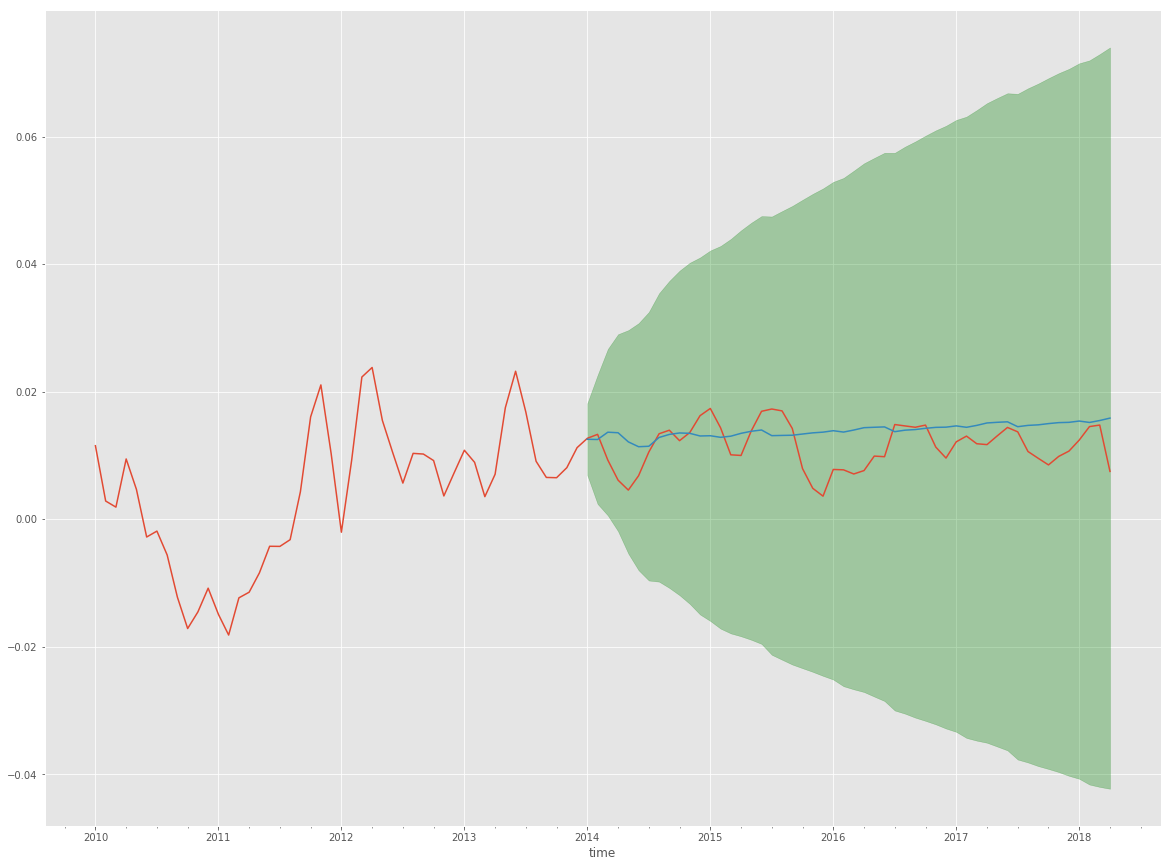

In [28]:
#from dynamic_forecast function above
dynamic_forecast(TS_80631,'2014-01-01', '2010-01-01')

The predicted values obtained from the dynamic forecast is 1.67e-5 which is slightly smaller than the one step forecast. Both the one step forecast and the dynamic forecast confirm that our time series is value. To complete this zipcode's time series analysis, we will predict up to the 10 year monthly returns.

In [ ]:
# Get dynamic predictions with confidence intervals 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
ax = TS_80631['2010':].plot(lw=5)
pred_dynamic.predicted_mean.plot(lw=5, ax=ax, alpha=.7)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')
ax.legend(['Observed','Dynamic Forecast'])

plt.show()

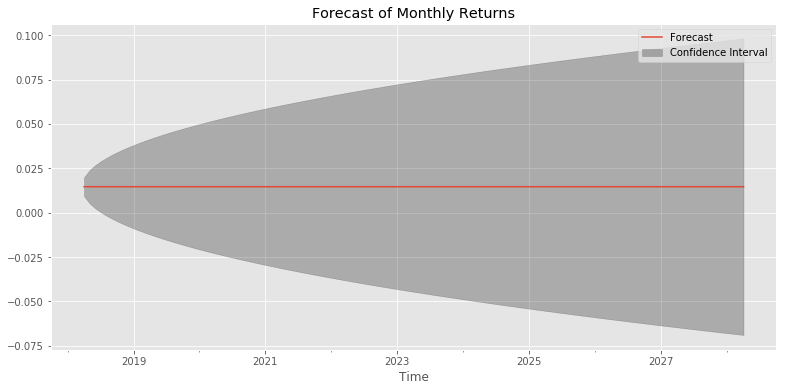

Total expected return in 1 year: 18.99%
Total expected return in 3 years: 68.48%
Total expected return in 5 year: 138.55%
Total expected return in 10 years: 477.37%


[80631,
 0.18990949999151097,
 0.6847962209389968,
 1.3855077265208622,
 4.773743781403046]

In [29]:
#from future_forecast_model function above
ret_80631 = future_forecast_model(TS_80631, pdq = pdq, pdqs = pdqs,zc=80631)
ret_80631

## 5.2 Modelling Zipcode 97233

Like the previous data, the data was not stationary so the plots for the ACF and PACF will be done with differenced data. The 'I' in the model will also be one.

In [ ]:
acf_pacf(TS_97233d)

In [ ]:
seasonal_plot(TS_97233d, N=13)

In [30]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [57]:
#run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
#try assigning global variables within these functions
def AIC(zipcode):
    global output
    global mod
    global ans
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try: 
                mod = sm.tsa.statespace.SARIMAX(zipcode,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue

In [58]:
AIC(97233)

In [31]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_97233,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [32]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2549.91
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1110.570
Date:                Wed, 23 Oct 2019   AIC                          -2215.140
Time:                        11:24:06   BIC                          -2204.865
Sample:                    05-01-1996   HQIC                         -2210.994
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2302      0.103     -2.225      0.026      -0.433      -0.027
ma.L1          0.7200      0.064     11.288      0.000       0.595       0.845
sigma2      3.288e-06    1.8e-07     18.314      0.0

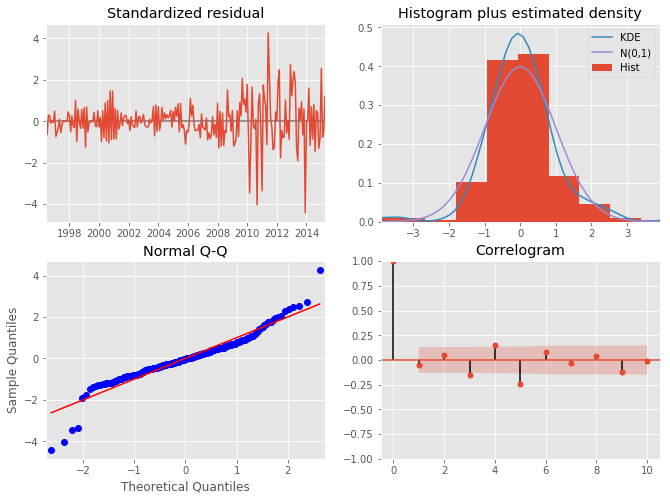

(time
 1996-05-01    0.006318
 1996-06-01    0.007175
 1996-07-01    0.006233
 1996-08-01    0.006195
 1996-09-01    0.007036
 1996-10-01    0.006987
 1996-11-01    0.006938
 1996-12-01    0.006891
 1997-01-01    0.007699
 1997-02-01    0.006791
 1997-03-01    0.005059
 1997-04-01    0.004195
 1997-05-01    0.004177
 1997-06-01    0.003328
 1997-07-01    0.002488
 1997-08-01    0.002481
 1997-09-01    0.002475
 1997-10-01    0.002469
 1997-11-01    0.002463
 1997-12-01    0.003276
 1998-01-01    0.004082
 1998-02-01    0.003252
 1998-03-01    0.003241
 1998-04-01    0.003231
 1998-05-01    0.002415
 1998-06-01    0.004016
 1998-07-01    0.003200
 1998-08-01    0.003190
 1998-09-01    0.003975
 1998-10-01    0.003167
                 ...   
 2012-11-01   -0.002761
 2012-12-01    0.001384
 2013-01-01    0.006220
 2013-02-01    0.010302
 2013-03-01    0.016315
 2013-04-01    0.021405
 2013-05-01    0.020301
 2013-06-01    0.015404
 2013-07-01    0.015171
 2013-08-01    0.016189
 2013-09-0

In [33]:
#Fit parameters for ARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
model_fit(TS_97233, pdq, pdqs)

From above, we can see that the KDE plot fits the N(0,1) closely and the the residuals on the the Q-Q plot closely follows that normally distributed line which tells us that the residuals are probably normally distributed. The standardized residual plot looks like mostly white noise and the autocorrelation plot shows us that the residuals are not closely related to lagged verisons of themselves. Now, we can validate our forecast.

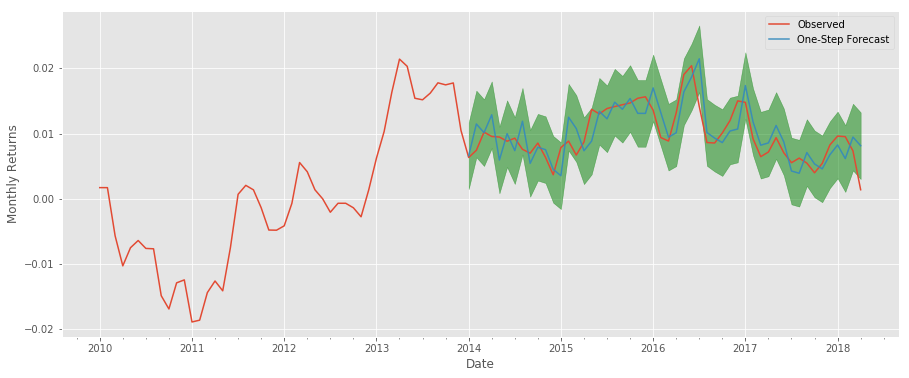

In [34]:
forecast(TS_97233,'2014-01-01', '2010-01-01')

NameError: name 'zipcode_forecasted' is not defined

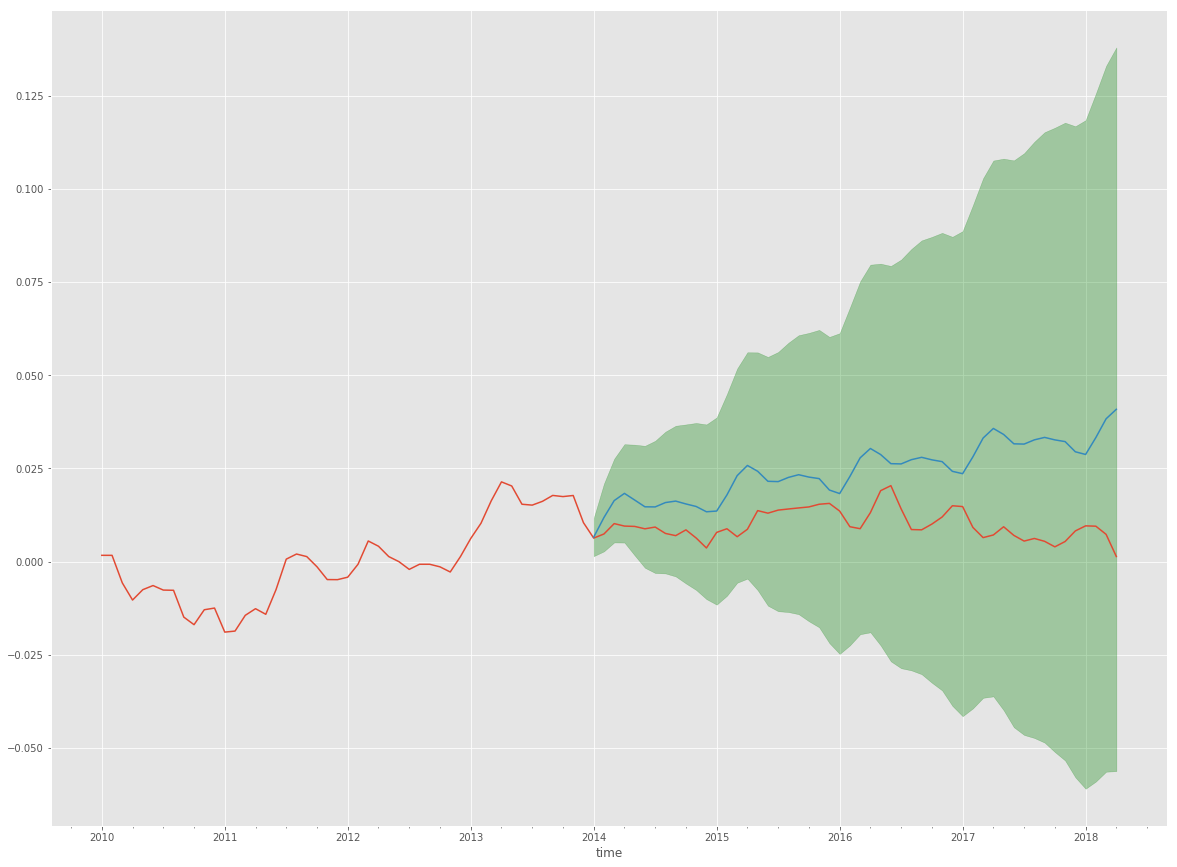

In [35]:
dynamic_forecast(TS_97233,'2014-01-01', '2010-01-01')

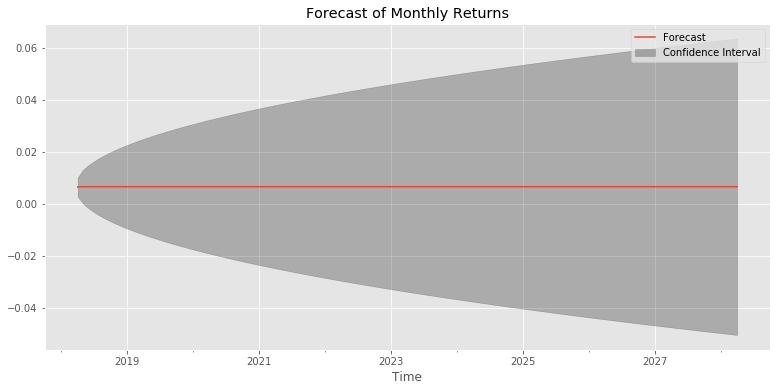

Total expected return in 1 year: 8.09%
Total expected return in 3 years: 26.32%
Total expected return in 5 year: 47.63%
Total expected return in 10 years: 119.38%


[97233,
 0.08092709027617606,
 0.2632303756055905,
 0.47627994173497323,
 1.19383708092019]

In [62]:
ret_97233 = future_forecast_model(TS_97233, pdq = pdq, pdqs = pdqs,zc=97233)
ret_97233

## 5.3 Modelling Zipcode 78758

Similar to the other monthly returns, because the data was not stationary we will use the differenced data in the ACF & PACF plots.

In [ ]:
acf_pacf(TS_78758d)

In [ ]:
seasonal_plot(TS_78758d, N=13)

While there is a statistically significant lag at 12 months, there are no other significant lags at other 12 month intervals, so it is probable that there is no seasonality in the data. Now, we will find the parameter for the model.

In [37]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_78758,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [38]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2507.19
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1139.065
Date:                Wed, 23 Oct 2019   AIC                          -2272.129
Time:                        11:31:12   BIC                          -2261.854
Sample:                    05-01-1996   HQIC                         -2267.983
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1568      0.124      1.267      0.205      -0.086       0.400
ma.L1          0.2656      0.129      2.058      0.040       0.013       0.519
sigma2       2.56e-06    2.1e-07     12.196      0.0

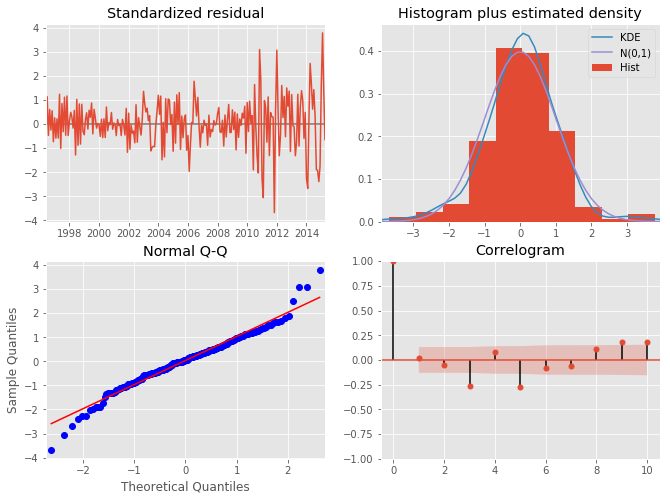

(time
 1996-05-01   -0.005426
 1996-06-01   -0.006235
 1996-07-01   -0.004706
 1996-08-01   -0.004728
 1996-09-01   -0.003959
 1996-10-01   -0.003975
 1996-11-01   -0.003192
 1996-12-01   -0.004003
 1997-01-01   -0.004019
 1997-02-01   -0.004843
 1997-03-01   -0.004866
 1997-04-01   -0.005705
 1997-05-01   -0.004098
 1997-06-01   -0.004938
 1997-07-01   -0.004136
 1997-08-01   -0.004153
 1997-09-01   -0.002502
 1997-10-01   -0.002508
 1997-11-01   -0.000838
 1997-12-01   -0.000839
 1998-01-01   -0.000840
 1998-02-01    0.000000
 1998-03-01    0.000840
 1998-04-01    0.000840
 1998-05-01    0.001678
 1998-06-01    0.000000
 1998-07-01    0.000838
 1998-08-01    0.000000
 1998-09-01    0.000837
 1998-10-01    0.000000
                 ...   
 2012-11-01    0.008646
 2012-12-01    0.007857
 2013-01-01    0.009213
 2013-02-01    0.009831
 2013-03-01    0.009736
 2013-04-01    0.007576
 2013-05-01    0.005468
 2013-06-01    0.006798
 2013-07-01    0.006077
 2013-08-01    0.006711
 2013-09-0

In [39]:
#Fit parameters for ARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
model_fit(TS_78758, pdq, pdqs)

One of the coefficients is not statistically significant but we can see the residuals are mostly normal with the tails in the Q-Q plot taper off. The standardized residuals also shows some white noise. 

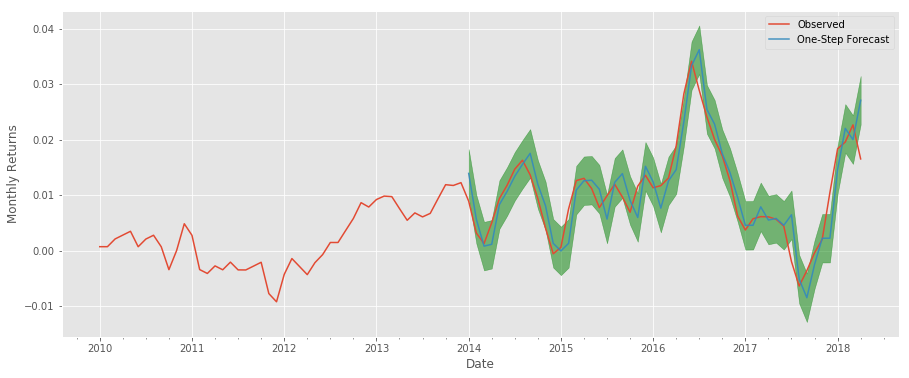

In [40]:
forecast(TS_78758,'2014-01-01', '2010-01-01')

NameError: name 'zipcode_forecasted' is not defined

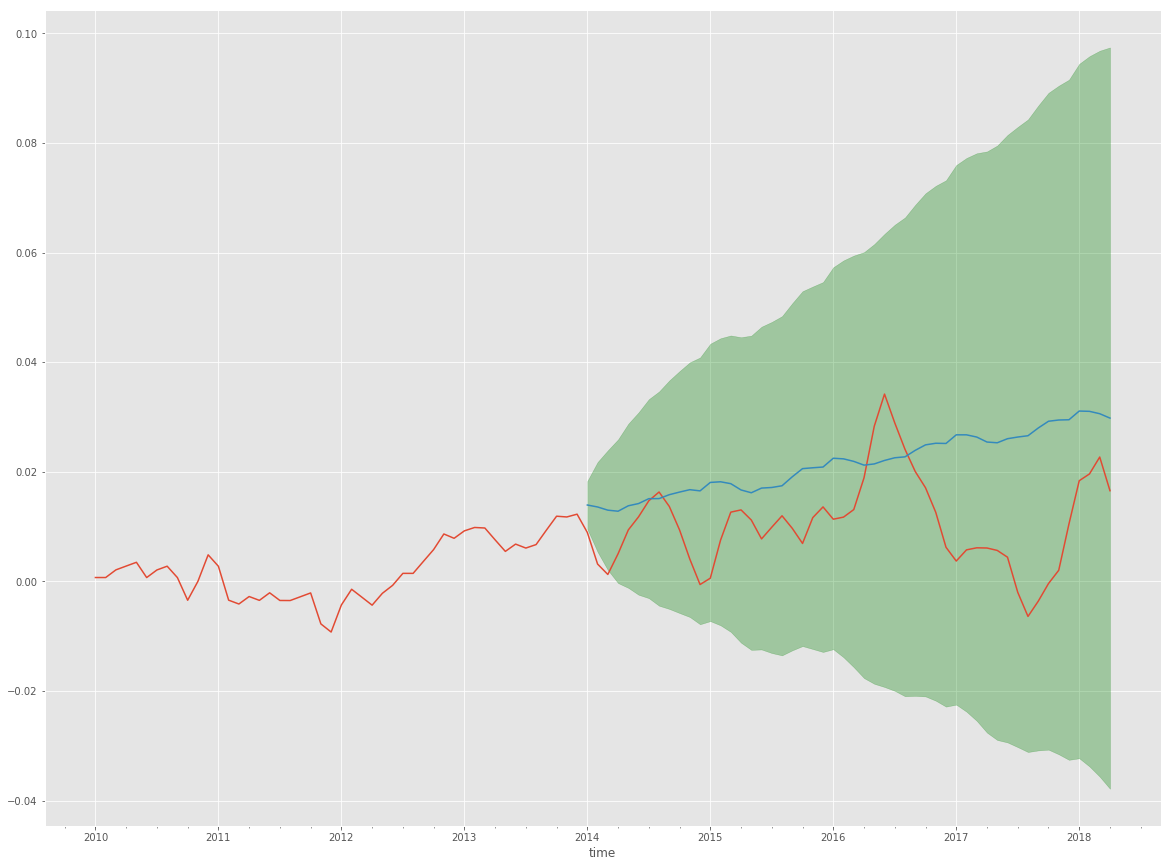

In [41]:
dynamic_forecast(TS_78758,'2014-01-01', '2010-01-01')

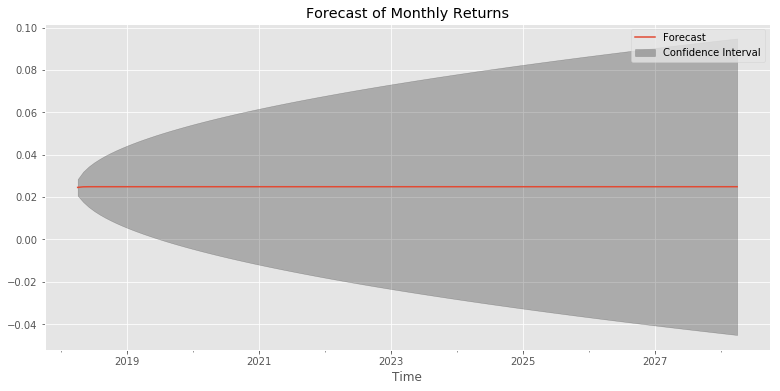

Total expected return in 1 year: 34.16%
Total expected return in 3 years: 141.68%
Total expected return in 5 year: 335.34%
Total expected return in 10 years: 1843.01%


[78758,
 0.34164228212090797,
 1.4167634919590588,
 3.3534300117861777,
 18.4300982623174]

In [64]:
ret_78758 = future_forecast_model(TS_78758, pdq = pdq, pdqs = pdqs,zc=78758)
ret_78758

## 5.4 Modelling Zipcode 98444

In [ ]:
acf_pacf(TS_98444d)

In [ ]:
seasonal_plot(TS_98444d, N=13)

In [43]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_98444,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [72]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic           -2443.9
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1067.201
Date:                Wed, 23 Oct 2019   AIC                          -2128.402
Time:                        11:36:14   BIC                          -2118.127
Sample:                    05-01-1996   HQIC                         -2124.256
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0462      0.146     -0.317      0.751      -0.332       0.239
ma.L1          0.3716      0.141      2.630      0.009       0.095       0.649
sigma2       4.81e-06    2.8e-07     17.185      0.0

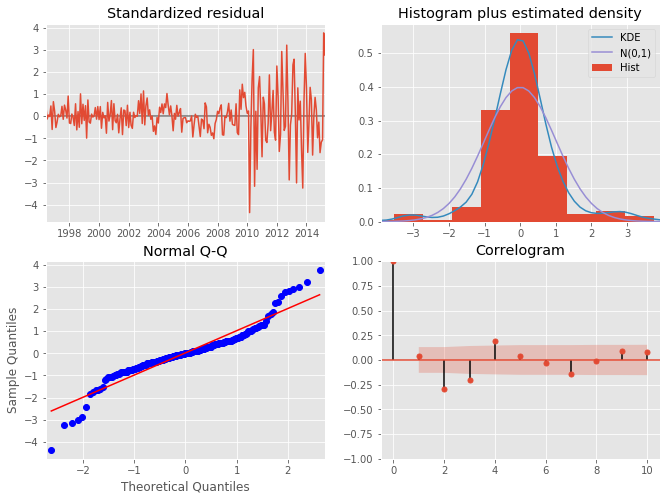

(time
 1996-05-01    0.000000
 1996-06-01    0.000996
 1996-07-01    0.000995
 1996-08-01    0.000994
 1996-09-01    0.000993
 1996-10-01    0.001984
 1996-11-01    0.000990
 1996-12-01    0.001978
 1997-01-01    0.002962
 1997-02-01    0.001969
 1997-03-01    0.000982
 1997-04-01    0.000981
 1997-05-01    0.000980
 1997-06-01    0.000979
 1997-07-01    0.001957
 1997-08-01    0.001953
 1997-09-01    0.002924
 1997-10-01    0.003887
 1997-11-01    0.003872
 1997-12-01    0.005786
 1998-01-01    0.005753
 1998-02-01    0.004766
 1998-03-01    0.004744
 1998-04-01    0.004721
 1998-05-01    0.003759
 1998-06-01    0.004682
 1998-07-01    0.003728
 1998-08-01    0.003714
 1998-09-01    0.002775
 1998-10-01    0.004613
                 ...   
 2012-11-01    0.002950
 2012-12-01    0.000000
 2013-01-01    0.000000
 2013-02-01    0.005147
 2013-03-01    0.012436
 2013-04-01    0.014451
 2013-05-01    0.007835
 2013-06-01    0.008481
 2013-07-01    0.009110
 2013-08-01    0.010417
 2013-09-0

In [44]:
#Fit parameters for ARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
model_fit(TS_98444, pdq, pdqs)

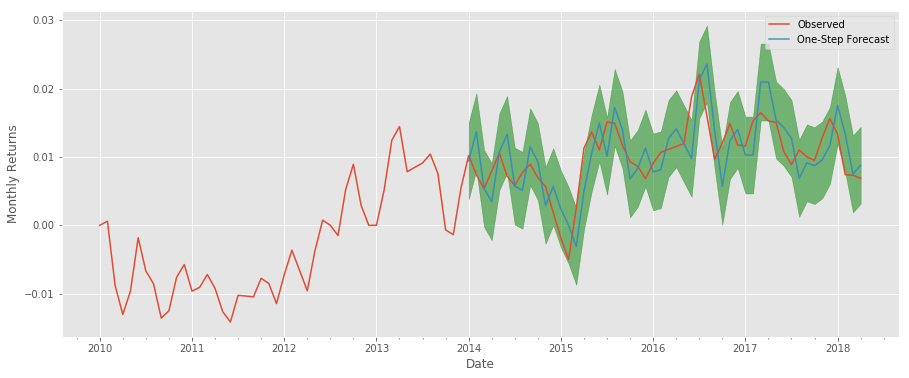

In [45]:
forecast(TS_98444,'2014-01-01', '2010-01-01')

NameError: name 'zipcode_forecasted' is not defined

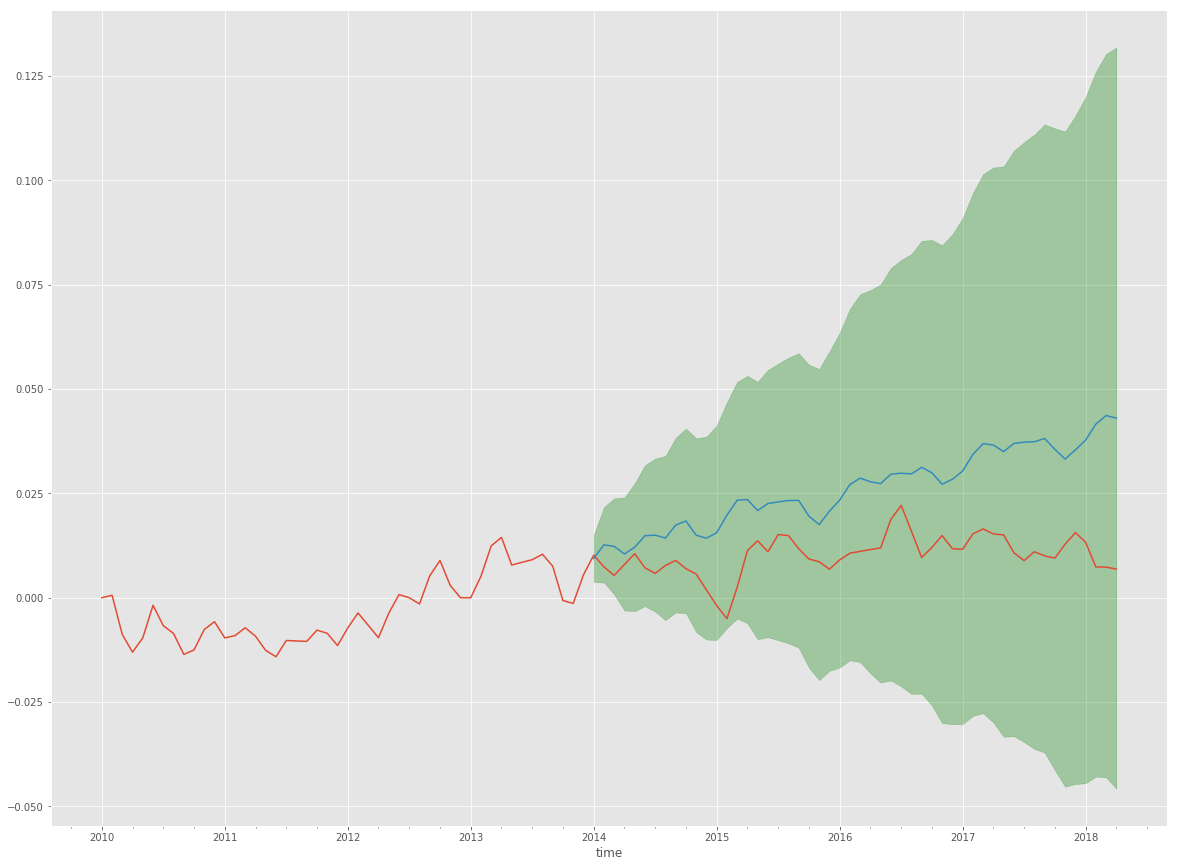

In [46]:
dynamic_forecast(TS_98444,'2014-01-01', '2010-01-01')

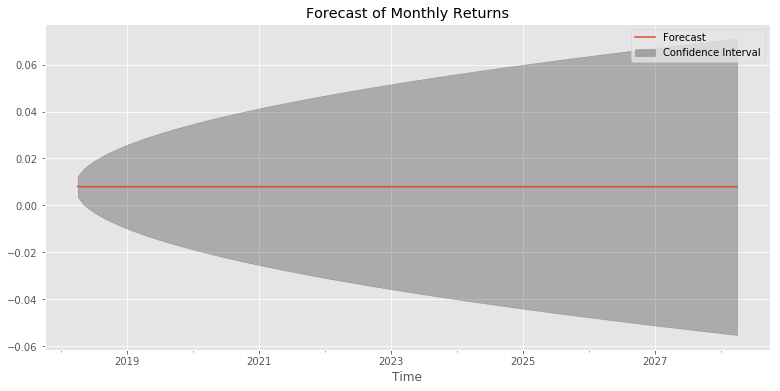

Total expected return in 1 year: 9.99%
Total expected return in 3 years: 33.04%
Total expected return in 5 year: 60.91%
Total expected return in 10 years: 160.97%


[98444,
 0.09988394269312062,
 0.33035720188434325,
 0.6091245775185599,
 1.6096708514180462]

In [61]:
ret_98444 = future_forecast_model(TS_98444, pdq = pdq, pdqs = pdqs,zc=98444)
ret_98444

## 5.5 Modelling Zipcode 37214

In [ ]:
acf_pacf(TS_37214d)

In [ ]:
seasonal_plot(TS_37214d, N=13)

In [47]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_37214,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [48]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2550.69
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1121.168
Date:                Wed, 23 Oct 2019   AIC                          -2236.336
Time:                        11:37:31   BIC                          -2226.061
Sample:                    05-01-1996   HQIC                         -2232.190
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1313      0.296     -0.444      0.657      -0.711       0.448
ma.L1          0.3105      0.309      1.006      0.314      -0.294       0.915
sigma2      3.003e-06   2.77e-07     10.860      0.0

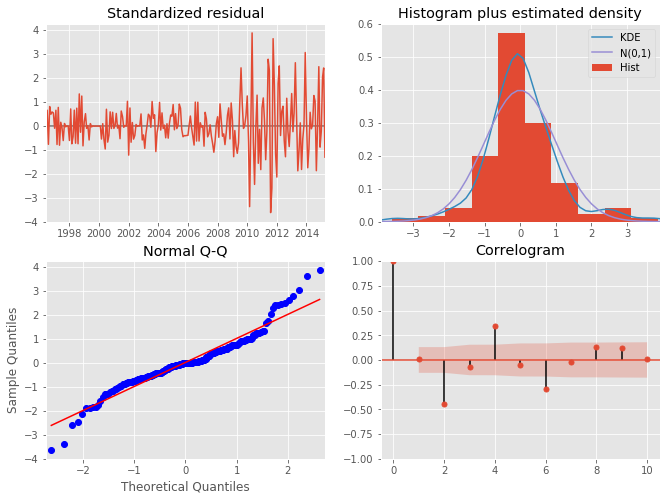

(time
 1996-05-01    0.001133
 1996-06-01    0.001131
 1996-07-01    0.002260
 1996-08-01    0.001127
 1996-09-01    0.002252
 1996-10-01    0.003371
 1996-11-01    0.004479
 1996-12-01    0.005574
 1997-01-01    0.005543
 1997-02-01    0.006615
 1997-03-01    0.005476
 1997-04-01    0.006536
 1997-05-01    0.005411
 1997-06-01    0.005382
 1997-07-01    0.005353
 1997-08-01    0.004260
 1997-09-01    0.004242
 1997-10-01    0.004224
 1997-11-01    0.004206
 1997-12-01    0.004188
 1998-01-01    0.003128
 1998-02-01    0.004158
 1998-03-01    0.003106
 1998-04-01    0.002064
 1998-05-01    0.003090
 1998-06-01    0.002053
 1998-07-01    0.003074
 1998-08-01    0.002043
 1998-09-01    0.004077
 1998-10-01    0.004061
                 ...   
 2012-11-01    0.001610
 2012-12-01    0.001608
 2013-01-01    0.004013
 2013-02-01    0.003997
 2013-03-01    0.004777
 2013-04-01    0.009509
 2013-05-01    0.010989
 2013-06-01    0.007764
 2013-07-01    0.005393
 2013-08-01    0.005364
 2013-09-0

In [49]:
#Fit parameters for ARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
model_fit(TS_37214, pdq, pdqs)

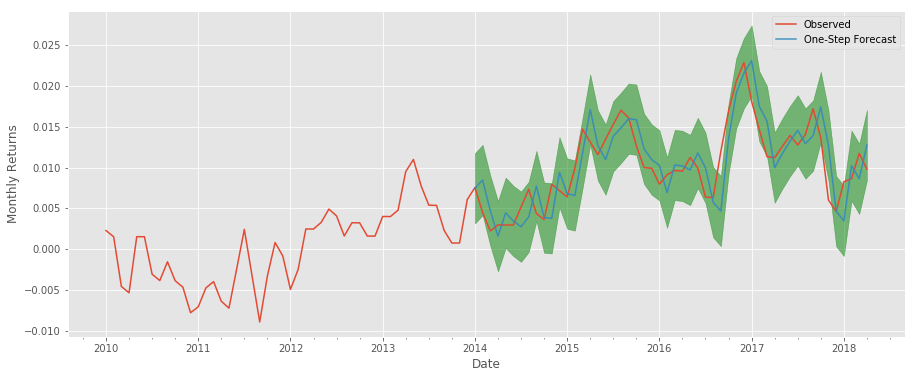

In [50]:
forecast(TS_37214,'2014-01-01', '2010-01-01')

NameError: name 'zipcode_forecasted' is not defined

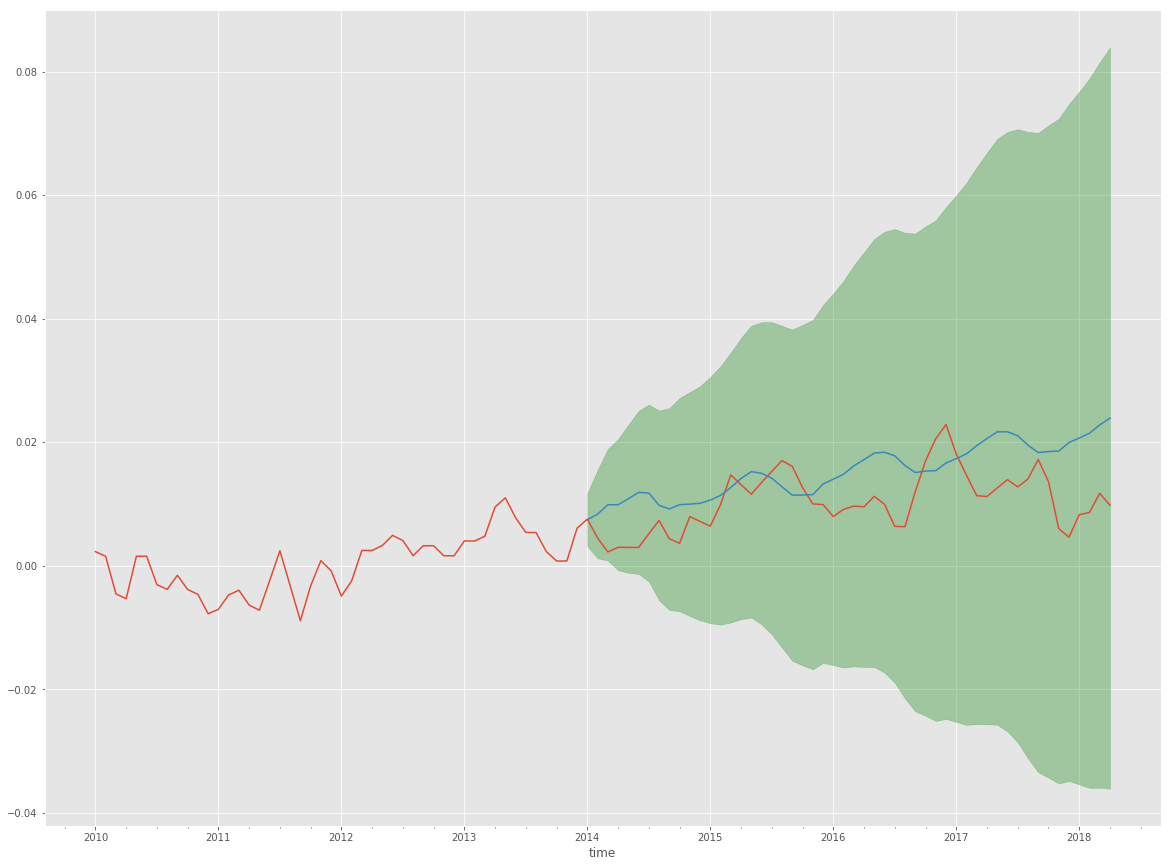

In [51]:
dynamic_forecast(TS_37214,'2014-01-01', '2010-01-01')

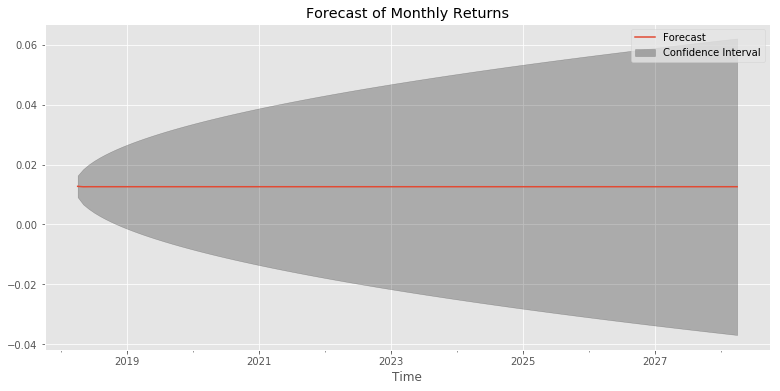

Total expected return in 1 year: 16.19%
Total expected return in 3 years: 56.83%
Total expected return in 5 year: 111.69%
Total expected return in 10 years: 353.72%


[37214,
 0.1619270811770983,
 0.568346620975624,
 1.1169238271250217,
 3.537230158032794]

In [60]:
ret_37214 = future_forecast_model(TS_37214, pdq = pdq, pdqs = pdqs,zc=37214)
ret_37214

# 6) Findings

After performing time series analyses on the five zipcodes and forecasting the returns up to ten years, I would recommend the real estate investment company to invest in the top three zipcodes:
1. 78758(Austin, TX) <br>
2. 98444(Parkland, WA) <br>
3. 80631 (Greeley, CO) <br>

The other two zipcodes do not have as high returns as the top three.

In [65]:
# put the future returns in a dataframe
tot_returns = [ret_37214, ret_98444, ret_78758, ret_80631, ret_97233]
tot_returns = pd.DataFrame(tot_returns, columns=['ZipCode', '1-year', '3-year', '5-year', '10-year'])
tot_returns.sort_values('10-year', ascending=False)

,ZipCode,1-year,3-year,5-year,10-year
2,78758,0.341642,1.416763,3.353430,18.430098
3,80631,0.189909,0.684796,1.385508,4.773744
0,37214,0.161927,0.568347,1.116924,3.537230
1,98444,0.099884,0.330357,0.609125,1.609671
4,97233,0.080927,0.263230,0.476280,1.193837


# 7) Future Work